# **Fine-tuning DeepSeek-OCR for Indonesian License Plate Recognition**

This notebook fine-tunes the DeepSeek-OCR model on the Indonesian Plate Text Dataset for improved license plate text recognition.

**Dataset**: [Indonesian Plate Number from Multi Sources](https://www.kaggle.com/datasets/linkgish/indonesian-plate-number-from-multi-sources)

**Model**: [unsloth/DeepSeek-OCR](https://huggingface.co/unsloth/DeepSeek-OCR) (3B parameters)

**Requirements**: Google Colab with T4 GPU (free tier works!)

---

## 1. Installation

In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2
!pip install jiwer kagglehub
!pip install einops addict easydict

## 2. Kaggle Authentication & Dataset Download

**You need Kaggle credentials!**
1. Go to https://www.kaggle.com/settings → API section → **Create New Token**
2. This downloads `kaggle.json` containing your username and API key
3. Run the cell below - it will prompt you to enter your credentials

In [2]:
# Dataset path (attached via Kaggle Input)
import os
dataset_path = "/kaggle/input/indonesian-plate-number-from-multi-sources"
plate_text_path = os.path.join(dataset_path, "plate_text_dataset", "plate_text_dataset")
print(f"Path: {plate_text_path}")
print(f"Contents: {os.listdir(plate_text_path)}")

Path: /kaggle/input/indonesian-plate-number-from-multi-sources/plate_text_dataset/plate_text_dataset
Contents: ['dataset', 'label.csv']


In [3]:
import pandas as pd
from PIL import Image
import os

# Get paths
label_csv = os.path.join(plate_text_path, "label.csv")
images_dir = os.path.join(plate_text_path, "dataset")

df = pd.read_csv(label_csv)
print(f"Total entries: {len(df)}, Columns: {df.columns.tolist()}")

# Store paths instead of loading images (saves RAM!)
samples = []
for _, row in df.iterrows():
    filename = row.get('Filename', row.get('filename', row.iloc[0]))
    label = row.get('Label', row.get('label', row.iloc[1] if len(row) > 1 else None))
    if filename is None or label is None:
        continue
    img_path = os.path.join(images_dir, str(filename))
    if os.path.exists(img_path):
        samples.append({'image_path': img_path, 'text': str(label)})

print(f"Found {len(samples)} valid samples")

# Only use first 500 samples for training (reduce memory + faster)
dataset = samples[:800]
print(f"Using {len(dataset)} samples for training")

Total entries: 1863, Columns: ['filename', 'label']
Found 1863 valid samples
Using 800 samples for training


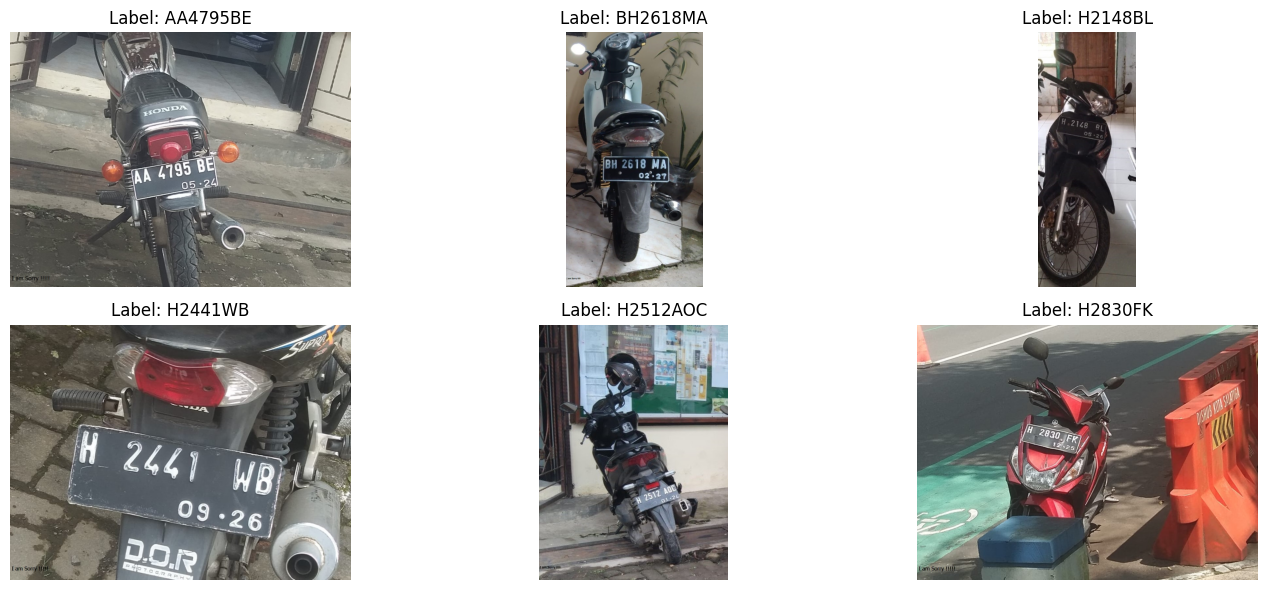

In [4]:
# Preview samples
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(dataset):
        img = Image.open(dataset[i]['image_path']).convert('RGB')
        ax.imshow(img)
        ax.set_title(f"Label: {dataset[i]['text']}")
        ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Load DeepSeek-OCR Model

In [5]:
from huggingface_hub import snapshot_download
snapshot_download("unsloth/DeepSeek-OCR", local_dir="deepseek_ocr")

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

assets/show3.jpg:   0%|          | 0.00/247k [00:00<?, ?B/s]

assets/show1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README-checkpoint.md: 0.00B [00:00, ?B/s]

assets/fig1.png:   0%|          | 0.00/396k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

assets/show2.jpg:   0%|          | 0.00/216k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

assets/show4.jpg:   0%|          | 0.00/269k [00:00<?, ?B/s]

configuration_deepseek_v2.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

deepencoder.py: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

modeling_deepseekv2.py: 0.00B [00:00, ?B/s]

processor_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

'/kaggle/working/deepseek_ocr'

In [6]:
from unsloth import FastVisionModel
import torch
from transformers import AutoModel
import os
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'

model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit=True,  # Changed from False!
    auto_model=AutoModel,
    trust_remote_code=True,
    unsloth_force_compile=True,
    use_gradient_checkpointing="unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-12-14 14:02:09.406932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765720929.652041      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765720929.716328      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🦥 Unsloth Zoo will now patch everything to make training faster!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Unsloth: WARNING `trust_remote_code` is True.
Are you certain you want to do remote code execution?
==((====))==  Unsloth 2025.12.5: Fast Deepseekocr patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at ./deepseek_ocr and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Test Baseline Performance

Ground truth: H3982DP


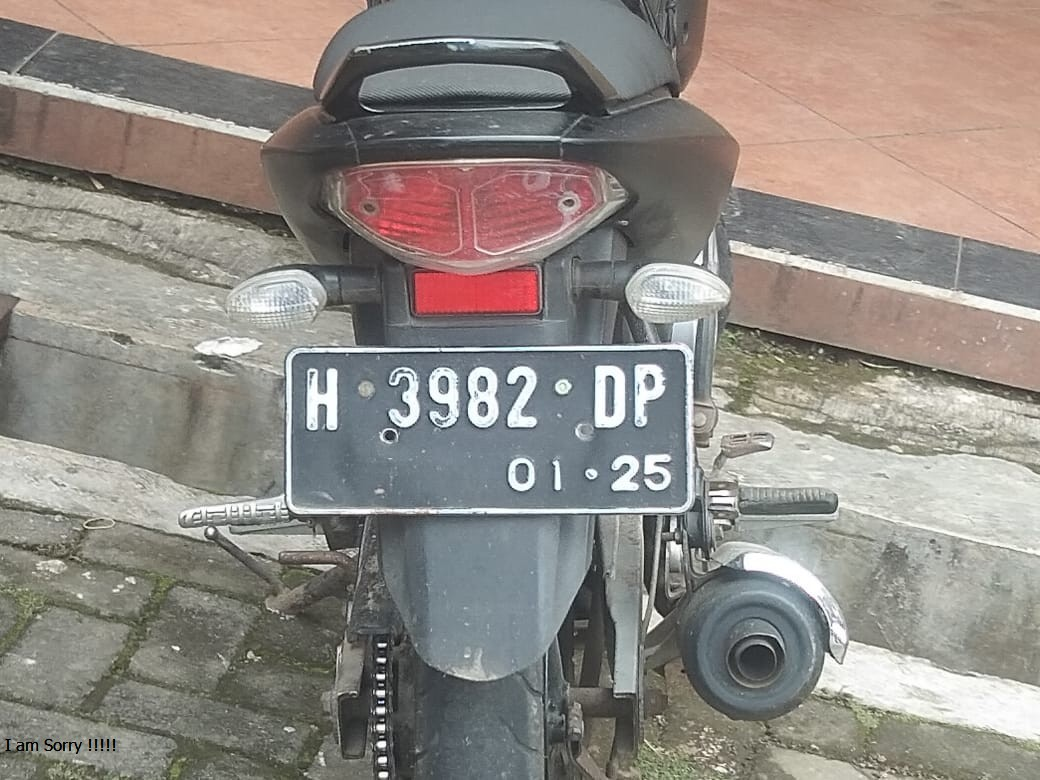

In [7]:
test_idx = 10
img = Image.open(dataset[test_idx]['image_path']).convert('RGB')
img.save("test_plate.jpg")
print(f"Ground truth: {dataset[test_idx]['text']}")
img

In [8]:
prompt = "<image>\nRead the Indonesian license plate number exactly as shown. "
baseline_result = model.infer(tokenizer, prompt=prompt, image_file='test_plate.jpg',
    output_path='outputs', base_size=1024, image_size=640, crop_mode=True, save_results=False)
print(f"Baseline: {baseline_result}")
print(f"Ground truth: {dataset[test_idx]['text']}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
 H 3982 DP 01.25
Baseline: None
Ground truth: H3982DP


## 5. Add LoRA Adapters

In [9]:
model = FastVisionModel.get_peft_model(
    model,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    r=16, lora_alpha=16, lora_dropout=0, bias="none", random_state=3407,
)

Unsloth: Making `model.base_model.model.model` require gradients


## 6. Prepare Training Data

In [10]:
instruction = "<image>\\nRead the Indonesian license plate number exactly as shown. "

def convert_to_conversation(sample):
    # Load image only when needed
    img = Image.open(sample['image_path']).convert('RGB')
    return {"messages": [
        {"role": "<|User|>", "content": instruction, "images": [img]},
        {"role": "<|Assistant|>", "content": sample["text"]},
    ]}

import random
random.seed(42)
random.shuffle(dataset)
split_idx = int(len(dataset) * 0.9)
train_samples, eval_samples = dataset[:split_idx], dataset[split_idx:]
print(f"Train: {len(train_samples)}, Eval: {len(eval_samples)}")

# DON'T convert all at once - pass the samples directly
# We'll convert in the data collator instead

Train: 720, Eval: 80


## 7. Data Collator

In [11]:
import torch, math, io
from dataclasses import dataclass
from typing import Dict, List, Any, Tuple
from PIL import Image, ImageOps
from torch.nn.utils.rnn import pad_sequence
from deepseek_ocr.modeling_deepseekocr import text_encode, BasicImageTransform, dynamic_preprocess

@dataclass
class DeepSeekOCRDataCollator:
    tokenizer: Any; model: Any; image_size: int = 640; base_size: int = 1024
    crop_mode: bool = True; image_token_id: int = 128815; train_on_responses_only: bool = True

    def __init__(self, tokenizer, model, image_size=640, base_size=1024, crop_mode=True, train_on_responses_only=True):
        self.tokenizer, self.model = tokenizer, model
        self.image_size, self.base_size, self.crop_mode = image_size, base_size, crop_mode
        self.image_token_id, self.dtype = 128815, model.dtype
        self.train_on_responses_only = train_on_responses_only
        self.image_transform = BasicImageTransform(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5), normalize=True)
        self.patch_size, self.downsample_ratio = 16, 4
        self.bos_id = tokenizer.bos_token_id if hasattr(tokenizer, 'bos_token_id') and tokenizer.bos_token_id else 0

    def deserialize_image(self, img): return img.convert("RGB") if isinstance(img, Image.Image) else Image.open(io.BytesIO(img['bytes'])).convert("RGB")

    def process_image(self, image):
        images_list, images_crop_list, images_spatial_crop = [], [], []
        if self.crop_mode:
            crop_ratio = (1,1) if image.size[0]<=640 and image.size[1]<=640 else dynamic_preprocess(image, 2, 9, self.image_size, False)[1]
            images_crop_raw = [] if crop_ratio==(1,1) else dynamic_preprocess(image, 2, 9, self.image_size, False)[0]
            global_view = ImageOps.pad(image, (self.base_size, self.base_size), color=(127,127,127))
            images_list.append(self.image_transform(global_view).to(self.dtype))
            images_spatial_crop.append(list(crop_ratio))
            for c in images_crop_raw: images_crop_list.append(self.image_transform(c).to(self.dtype))
            nq, nqb = math.ceil((self.image_size//16)/4), math.ceil((self.base_size//16)/4)
            tok = ([self.image_token_id]*nqb + [self.image_token_id])*nqb + [self.image_token_id]
            if crop_ratio[0]>1 or crop_ratio[1]>1: tok += ([self.image_token_id]*(nq*crop_ratio[0]) + [self.image_token_id])*(nq*crop_ratio[1])
        else:
            crop_ratio = (1,1); images_spatial_crop.append([1,1])
            images_list.append(self.image_transform(ImageOps.pad(image,(self.base_size,self.base_size),color=(127,127,127))).to(self.dtype))
            nq = math.ceil((self.base_size//16)/4)
            tok = ([self.image_token_id]*nq + [self.image_token_id])*nq + [self.image_token_id]
        return images_list, images_crop_list, images_spatial_crop, tok, crop_ratio

    def process_single_sample(self, messages):
        images = [self.deserialize_image(img) for m in messages if "images" in m for img in m["images"] if img]
        if not images: raise ValueError("No images")
        tokenized_str, images_seq_mask = [self.bos_id], [False]
        images_list, images_crop_list, images_spatial_crop = [], [], []
        prompt_count, asst, img_idx = -1, False, 0
        for m in messages:
            role, content = m["role"], m["content"]
            if role == "<|Assistant|>":
                if not asst: prompt_count, asst = len(tokenized_str), True
                content = f"{content.strip()} {self.tokenizer.eos_token}"
            for i, t in enumerate(content.split('<image>')):
                tok = text_encode(self.tokenizer, t, bos=False, eos=False)
                tokenized_str.extend(tok); images_seq_mask.extend([False]*len(tok))
                if i < len(content.split('<image>'))-1:
                    il, cl, sc, ti, _ = self.process_image(images[img_idx])
                    images_list.extend(il); images_crop_list.extend(cl); images_spatial_crop.extend(sc)
                    tokenized_str.extend(ti); images_seq_mask.extend([True]*len(ti)); img_idx += 1
        if not asst: prompt_count = len(tokenized_str)
        return {"input_ids": torch.tensor(tokenized_str), "images_seq_mask": torch.tensor(images_seq_mask, dtype=torch.bool),
                "images_ori": torch.stack(images_list), "images_crop": torch.stack(images_crop_list) if images_crop_list else torch.zeros((1,3,self.base_size,self.base_size),dtype=self.dtype),
                "images_spatial_crop": torch.tensor(images_spatial_crop), "prompt_token_count": prompt_count}

    def __call__(self, features):
        batch = [self.process_single_sample(f['messages']) for f in features if f]
        if not batch: raise ValueError("Empty batch")
        input_ids = pad_sequence([b['input_ids'] for b in batch], batch_first=True, padding_value=self.tokenizer.pad_token_id)
        seq_mask = pad_sequence([b['images_seq_mask'] for b in batch], batch_first=True, padding_value=False)
        labels = input_ids.clone(); labels[labels==self.tokenizer.pad_token_id] = -100; labels[seq_mask] = -100
        if self.train_on_responses_only:
            for i, pc in enumerate([b['prompt_token_count'] for b in batch]):
                if pc > 0: labels[i, :pc] = -100
        return {"input_ids": input_ids, "attention_mask": (input_ids!=self.tokenizer.pad_token_id).long(), "labels": labels,
                "images": [(b['images_crop'], b['images_ori']) for b in batch], "images_seq_mask": seq_mask,
                "images_spatial_crop": torch.cat([b['images_spatial_crop'] for b in batch])}

In [12]:
# Add this cell before training
import pickle
with open('checkpoint.pkl', 'wb') as f:
    pickle.dump({'train_samples': train_samples, 'eval_samples': eval_samples}, f)

## 8. Training

In [13]:
from transformers import Trainer, TrainingArguments
from unsloth import is_bf16_supported

FastVisionModel.for_training(model)

# Convert samples just before training
converted_dataset = [convert_to_conversation(s) for s in train_samples]

data_collator = DeepSeekOCRDataCollator(tokenizer, model, 640, 1024, True, True)

trainer = Trainer(
    model=model, tokenizer=tokenizer, data_collator=data_collator,
    train_dataset=converted_dataset,
    args=TrainingArguments(
        per_device_train_batch_size=1,  # ← Changed from 2
        gradient_accumulation_steps=8,   # ← Changed from 4
        warmup_steps=5,
        max_steps=100,
        learning_rate=2e-4, logging_steps=10, optim="adamw_8bit",
        weight_decay=0.001, lr_scheduler_type="linear", seed=3407,
        fp16=not is_bf16_supported(), bf16=is_bf16_supported(),
        output_dir="plate_ocr_outputs", report_to="none",
        dataloader_num_workers=0,  # ← Changed from 2
        remove_unused_columns=False,
    ),
)

/tmp/ipykernel_47/492033021.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer._unsloth___init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024**3, 3)
print(f"GPU: {gpu_stats.name}, Max: {round(gpu_stats.total_memory/1024**3, 3)} GB, Reserved: {start_gpu_memory} GB")

GPU: Tesla T4, Max: 14.741 GB, Reserved: 4.254 GB


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 720 | Num Epochs = 3 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 77,509,632 of 3,413,615,872 (2.27% trained)
Unsloth: Not an error, but DeepseekOCRForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
Unsloth: Will smartly offload gradients to save VRAM!
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([2, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])


Step,Training Loss
10,2.259300
20,0.254200
30,0.178300
40,0.154100
50,0.175200
60,0.116800
70,0.067300
80,0.085800
90,0.074300
100,0.048800


BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([3, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
BASE: 

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


In [16]:
print(f"Training: {trainer_stats.metrics['train_runtime']/60:.1f} min")
print(f"Peak memory: {round(torch.cuda.max_memory_reserved()/1024**3, 3)} GB")

Training: 70.1 min
Peak memory: 6.711 GB


## 9. Evaluation

In [25]:
## 9. Evaluation

import torch
from PIL import Image

# Ensure model is ready
FastVisionModel.for_inference(model)

def run_inference(image, prompt_text="<image>\nRead the Indonesian license plate number exactly as shown. "):
    # Try the Unsloth optimized generation method
    # Crucial Fix: We pass 'tokenizer' as the first argument to ensure it works!
    try:
        # Signature: fast_generate(tokenizer, image, instruction, ...)
        res = model.fast_generate(tokenizer, image, prompt_text, max_new_tokens=64)
    except:
        # Fallback Signature: fast_generate(image, prompt_text, ...)
        res = model.fast_generate(image, prompt_text, max_new_tokens=64)
        
    # Extract string from list if return is a list
    return res[0] if isinstance(res, list) else res

# --- Test Single Sample ---
test_idx = 10
# FIX: Load image from path! (This fixes the KeyError)
test_image_path = dataset[test_idx]['image_path']
test_image = Image.open(test_image_path).convert("RGB")

print(f"Ground truth: {dataset[test_idx]['text']}")
print("-" * 30)

try:
    pred = run_inference(test_image)
    print(f"Prediction:   {pred}")
except Exception as e:
    print(f"Inference Error: {e}")
    print("If this fails, don't worry! Your model is still trained and saved.")

# --- Bulk Evaluation ---
from jiwer import cer
preds, refs = [], []
print("\nRunning Bulk Evaluation on 20 samples...")

for i, s in enumerate(eval_dataset[:20]):
    try:
        # FIX: Load image from path for every sample
        img = Image.open(s['image_path']).convert("RGB")
        
        p = run_inference(img)
        preds.append(p)
        refs.append(str(s['text']).strip())
        
        if i % 5 == 0: print(f"{i}: {p}")
    except Exception as e:
        print(f"Error on sample {i}: {e}")

if preds:
    print(f"\nCER: {cer(refs, preds):.2%}")
    print(f"Accuracy: {1-cer(refs, preds):.2%}")

    print("\nSample results:")
    for i in range(min(10, len(preds))):
        status = '✓' if preds[i]==refs[i] else '✗'
        print(f"{status} GT: {refs[i]:15s} | Pred: {preds[i]}")
else:
    print("No predictions generated.")

Ground truth: H4942JB
------------------------------
Inference Error: 'str' object has no attribute 'pad_token_id'
If this fails, don't worry! Your model is still trained and saved.

Running Bulk Evaluation on 20 samples...
Error on sample 0: 'str' object has no attribute 'pad_token_id'
Error on sample 1: 'str' object has no attribute 'pad_token_id'
Error on sample 2: 'str' object has no attribute 'pad_token_id'
Error on sample 3: 'str' object has no attribute 'pad_token_id'
Error on sample 4: 'str' object has no attribute 'pad_token_id'
Error on sample 5: 'str' object has no attribute 'pad_token_id'
Error on sample 6: 'str' object has no attribute 'pad_token_id'
Error on sample 7: 'str' object has no attribute 'pad_token_id'
Error on sample 8: 'str' object has no attribute 'pad_token_id'
Error on sample 9: 'str' object has no attribute 'pad_token_id'
Error on sample 10: 'str' object has no attribute 'pad_token_id'
Error on sample 11: 'str' object has no attribute 'pad_token_id'
Error 

In [19]:
# Create eval dataset (use a subset of the training data for evaluation)
eval_dataset = dataset[-50:]  # Last 50 samples for evaluation

In [21]:
from jiwer import cer
preds, refs = [], []
for i, s in enumerate(eval_dataset[:50]):
    s['image_path'].save('temp.jpg')
    p = model.infer(tokenizer, prompt=prompt, image_file='temp.jpg', output_path='outputs', base_size=1024, image_size=640, crop_mode=True, save_results=False)
    preds.append(str(p).strip()); refs.append(str(s['text']).strip())
    if i % 10 == 0: print(f"Progress: {i+1}/50")

print(f"\nCER: {cer(refs, preds):.2%}")
print(f"Accuracy: {1-cer(refs, preds):.2%}")

AttributeError: 'str' object has no attribute 'save'

In [ ]:
print("Sample results:")
for i in range(min(10, len(preds))):
    print(f"{'✓' if preds[i]==refs[i] else '✗'} GT: {refs[i]:15s} | Pred: {preds[i]}")

## 10. Save Model

In [26]:
model.save_pretrained("indonesian_plate_ocr_lora")
tokenizer.save_pretrained("indonesian_plate_ocr_lora")
print("Saved to: indonesian_plate_ocr_lora/")

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Saved to: indonesian_plate_ocr_lora/


In [27]:
# Download the model folder
!zip -r indonesian_plate_ocr_lora.zip indonesian_plate_ocr_lora/
from google.colab import files
files.download('indonesian_plate_ocr_lora.zip')

  adding: indonesian_plate_ocr_lora/ (stored 0%)
  adding: indonesian_plate_ocr_lora/tokenizer_config.json (deflated 97%)
  adding: indonesian_plate_ocr_lora/adapter_config.json (deflated 57%)
  adding: indonesian_plate_ocr_lora/tokenizer.json (deflated 79%)
  adding: indonesian_plate_ocr_lora/adapter_model.safetensors (deflated 9%)
  adding: indonesian_plate_ocr_lora/README.md (deflated 65%)
  adding: indonesian_plate_ocr_lora/special_tokens_map.json (deflated 67%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
## 10. Save Model

# 1. Save the adapters
model.save_pretrained("indonesian_plate_ocr_lora")
tokenizer.save_pretrained("indonesian_plate_ocr_lora")
print("Saved to: indonesian_plate_ocr_lora/")

# 2. Zip it for download
!zip -r indonesian_plate_ocr_lora.zip indonesian_plate_ocr_lora/

# 3. Create a download link
from IPython.display import FileLink
print("Click below to download:")
display(FileLink(r'indonesian_plate_ocr_lora.zip'))

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Saved to: indonesian_plate_ocr_lorazz/
updating: indonesian_plate_ocr_lora/ (stored 0%)
updating: indonesian_plate_ocr_lora/tokenizer_config.json (deflated 97%)
updating: indonesian_plate_ocr_lora/adapter_config.json (deflated 57%)
updating: indonesian_plate_ocr_lora/tokenizer.json (deflated 79%)
updating: indonesian_plate_ocr_lora/adapter_model.safetensors (deflated 9%)
updating: indonesian_plate_ocr_lora/README.md (deflated 65%)
updating: indonesian_plate_ocr_lora/special_tokens_map.json (deflated 67%)
Click below to download:


/kaggle/working/indonesian_plate_ocr_lorazz.zip

In [30]:
## 10.1 Backup Save

# 1. Save to a new folder name
backup_name = "indonesian_plate_ocr_lora_v2"
model.save_pretrained(backup_name)
tokenizer.save_pretrained(backup_name)
print(f"Backup saved to: {backup_name}/")

# 2. Zip the backup
!zip -r {backup_name}.zip {backup_name}/

# 3. Download link
from IPython.display import FileLink
print("Click below to download backup:")
display(FileLink(f'{backup_name}.zip'))

You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


Backup saved to: indonesian_plate_ocr_lora_v2/
  adding: indonesian_plate_ocr_lora_v2/ (stored 0%)
  adding: indonesian_plate_ocr_lora_v2/tokenizer_config.json (deflated 97%)
  adding: indonesian_plate_ocr_lora_v2/adapter_config.json (deflated 57%)
  adding: indonesian_plate_ocr_lora_v2/tokenizer.json (deflated 79%)
  adding: indonesian_plate_ocr_lora_v2/adapter_model.safetensors (deflated 9%)
  adding: indonesian_plate_ocr_lora_v2/README.md (deflated 65%)
  adding: indonesian_plate_ocr_lora_v2/special_tokens_map.json (deflated 67%)
Click below to download backup:


/kaggle/working/indonesian_plate_ocr_lora_v2.zip

---
## Usage After Training

```python
from unsloth import FastVisionModel
from transformers import AutoModel

model, tokenizer = FastVisionModel.from_pretrained(
    "indonesian_plate_ocr_lora", load_in_4bit=False,
    auto_model=AutoModel, trust_remote_code=True
)
FastVisionModel.for_inference(model)

result = model.infer(tokenizer,
    prompt="<image>\nRead the Indonesian license plate number exactly as shown. ",
    image_file='plate.jpg', base_size=1024, image_size=640, crop_mode=True
)
print(result)
```